In [12]:
cd("/Users/federicoclaudi/Documents/Github/LocomotionControl/analysis/behavior")
import Pkg; 
Pkg.activate(".")

using Plots, CSV, Term
import Term: install_term_logger
import MyterialColors: salmon, green_dark, blue_grey_darker
using Statistics
import DataFrames: DataFrame
using MultiKDE
using StatsBase

using jcontrol
using jcontrol.visuals
import jcontrol.visuals: arena
import jcontrol.comparisons: ComparisonPoints
import jcontrol.io: PATHS

install_term_logger()

  Activating project at `~/Documents/Github/LocomotionControl/analysis/behavior`


Term.logging.TermLogger(VSCodeServer.IJuliaCore.IJuliaStdio{Base.PipeEndpoint, typeof(VSCodeServer.io_send_callback)}(IOContext(Base.PipeEndpoint(RawFD(22) open, 0 bytes waiting)), VSCodeServer.io_send_callback), Term.Theme
  docstring: String "#66BB6A"
  string: String "#A5D6A7"
  type: String "#CE93D8"
  emphasis: String "#42A5F5  bold"
  emphasis_light: String "#A5D6A7"
  code: String "#90CAF9"
  multiline_code: String "#90CAF9"
  symbol: String "#FFCC80"
  expression: String "#F48FB1"
  number: String "#42A5F5"
  operator: String "#EF5350 bold"
  func: String "#FFEE58"
  info: String "#42A5F5"
  debug: String "#42A5F5"
  warn: String "#FFA726"
  error: String "bold #EF5350"
  tree_title_style: String "#FFA726 italic"
  tree_node_style: String "#FFEE58 italic"
  tree_leaf_style: String "#FFF59D"
  tree_guide_style: String "#42A5F5"
)

## Figure 5

Show that the global MTM solution is a good representation of the animals traces.

In [49]:
# load trials
trials = load_cached_trials(; keep_n = nothing);
@info "Loaded $(length(trials)) trials"

S = getfield.(trials, :s)
speed = map(t -> sqrt.(t.u .^ 2 .+ t.v .^ 2), trials)
U = getfield.(trials, :u)
Ω = getfield.(trials, :ω);

# load comparison points
cpoints = ComparisonPoints(FULLTRACK; δs=1, trials=trials, s₀=1.0, s₁=250.0);


@Info (Main):  Loaded 580 trials
  ╰────────────────────────────────────────────────
                      Tue, 12 Apr 2022 16:26:31


In [113]:
# create trials speed and angular velocity heatmaps
speed = zeros(250, 100)
ω = zeros(250, 30)

for (n, cp) in enumerate(cpoints.points[3:end-1])
    sp = fit(Histogram, cp.kinematics.u.values, 1:101)
    speed[n, :] .= sp.weights


    angvel = fit(Histogram, cp.kinematics.ω.values, -15:15)
    ω[n, :] .= angvel.weights
end

# length(cpoints.points[2:end-1])
# # getfield.(cpoints.points[2:end-1], :s)
# heatmap(speed', color=color=cgrad(:Blues_9, [.05, .25, .5, 1.0]))

In [6]:
# load MTM global solution
globalsolution = DataFrame(CSV.File(joinpath(PATHS["horizons_sims_cache"], "global_solution.csv")))
globalsolution = Solution(globalsolution);
gs_speed = sqrt.(globalsolution.u .^ 2 .+ globalsolution.v .^ 2)


### make plot

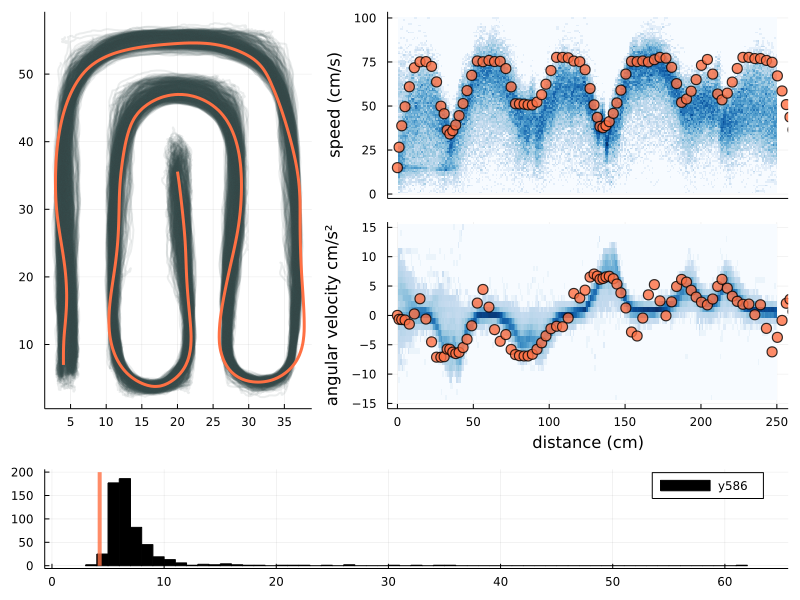

In [130]:
layout = @layout [
    a{0.4w} grid(2, 1)
    c{.2h}
]

fig = plot(; layout=layout, size=(800, 600))


plot!.(
    getfield.(trials, :x), 
    getfield.(trials, :y), 
    color=blue_grey_darker, 
    lw=2, alpha=.1, subplot=1,
    label=nothing,
)
plot!(; subplot=1, aspect_ratio=:equal, xlim=[-5, 45], ylim=[-5, 65],)

plot!(
    globalsolution.x, globalsolution.y,
    lw=3, color=salmon, label=nothing, subplot=1
)

# plot trials kinematics heatmap
heatmap!(speed', 
    color=cgrad(:Blues_9, [.05, .25, .5, 1.0]),
    subplot=2,
    colorbar=false,
)
heatmap!(
    1:size(ω,1),
    (1-15):(size(ω,2)-15),
    ω', 
    colorbar=false,
    color=cgrad(:Blues_9, [.01, .25, .5, 1.0]),
    subplot=3
)

# plot solution kinematics
scatter!(globalsolution.s[1:5:end], gs_speed[1:5:end], 
            ms=6, alpha=.8, color=salmon, label=nothing, subplot=2)
scatter!(globalsolution.s[1:5:end], globalsolution.ω[1:5:end], 
            ms=6, alpha=.8, color=salmon, label=nothing, subplot=3)

# plot trials durations histogram
histogram!(
    getfield.(trials, :duration), 
    bins=100, 
    color="black", 
    subplot=4,
    colorbar=false, label=nothing,
)
plot!(
    [globalsolution.t[end], globalsolution.t[end]], [0, 200], subplot=4,
    lw=4, color=salmon, alpha=.8, label=nothing
)


# set plot properties
plot!(; subplot=2, xlim=[1, 250], xticks=[], ylabel="speed (cm/s)")
plot!(; subplot=3, ylim=[-15, 15], xlim=[1, 250], xlabel="distance (cm)", ylabel="angular velocity cm/s²")
display(fig)